In [1]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer
from scipy.io import loadmat
import yaml

sys.path.append("../")


from models import  FNN_train, compute_2dFourier_bases, compute_2dpca_bases, count_params
from models.myGkNN6 import myGkNN6

torch.set_printoptions(precision=16)


torch.manual_seed(0)
np.random.seed(0)


###################################
# load configs
###################################
with open('config.yml', 'r', encoding='utf-8') as f:
    config = yaml.full_load(f)

config = config["airfoil_test6"]
config = dict(config)
config_data, config_model, config_train = (
    config["data"],
    config["model"],
    config["train"],
)
downsample_ratio = config_data["downsample_ratio"]
L = config_data["L"]
n_train = config_data["n_train"]
n_test = config_data["n_test"]
device = torch.device(config["train"]["device"])


###################################
# load data
###################################
data_path = "../data/airfoil/"
coordx = np.load(data_path+"NACA_Cylinder_X.npy")
coordy = np.load(data_path+"NACA_Cylinder_Y.npy")
data_in = np.stack((coordx, coordy), axis=3)
data_out = np.load(data_path+"NACA_Cylinder_Q.npy")[:,4,:,:] #density, velocity 2d, pressure, mach number


data_in.shape (2490, 221, 51, 2)
data_out.shape (2490, 221, 51)
(2490, 5, 221, 51)
(221, 51) (221, 51)


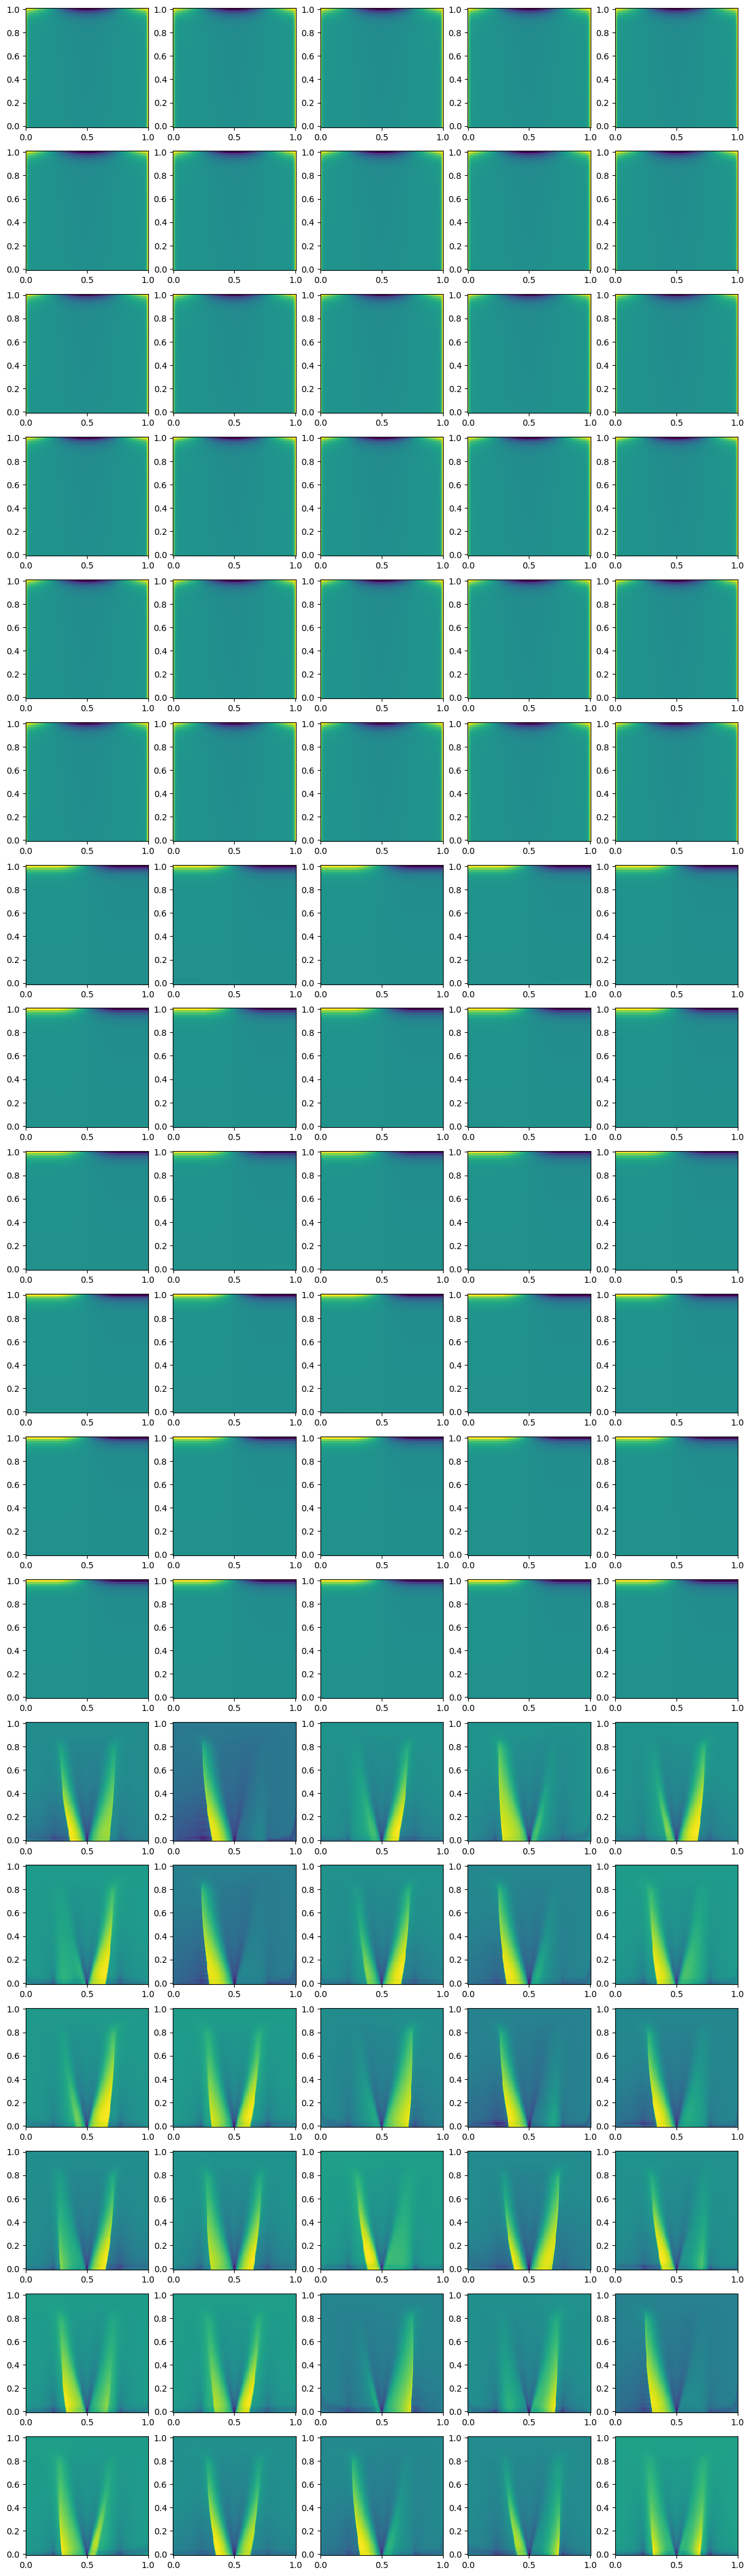

In [2]:

print('data_in.shape',data_in.shape)
print('data_out.shape',data_out.shape)
print(np.load(data_path+"NACA_Cylinder_Q.npy").shape)
Nx = 221
Ny = 51
mygridx = np.linspace(0, L, Nx)
mygridy = np.linspace(0, L, Ny)
grid_x, grid_y = np.meshgrid(mygridx, mygridy)
print(grid_x.T.shape, grid_y.T.shape)
m=18
n=5
fig, axs = plt.subplots(m, n, figsize=(3*n,3*m))
A = 221
B = 51
for i in range(5):
    j=0
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_in[i,:A,-B:,0])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_in[i+100,:A,-B:,0])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_in[i+300,:A,-B:,0])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_in[i+1000,:A,-B:,0])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_in[i+1500,:A,-B:,0])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_in[i+2000,:A,-B:,0])
    j=j+1


    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_in[i,:A,-B:,1])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_in[i+100,:A,-B:,1])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_in[i+300,:A,-B:,1])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_in[i+1000,:A,-B:,1])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_in[i+1500,:A,-B:,1])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_in[i+2000,:A,-B:,1])
    j=j+1

    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_out[i,:A,-B:])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_out[i+100,:A,-B:])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_out[i+300,:A,-B:])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_out[i+1000,:A,-B:])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_out[i+1500,:A,-B:])
    j=j+1
    axs[j,i].pcolormesh(grid_x.T[:A,-B:], grid_y.T[:A,-B:], data_out[i+2000,:A,-B:])
    j=j+1


In [35]:
data_path = "../data/airfoil/"
data = np.load(data_path+"NACA_Cylinder_X.npy")
print(data.shape)  #(2490, 221, 51)

data = torch.from_numpy(data)
N = data.shape[0]
sample1 = data[0,:,:].unsqueeze(0)

error = data - sample1.repeat(N,1,1)

print(  torch.norm(error)  ,  error.any()  )

(2490, 221, 51)
tensor(0., dtype=torch.float64) tensor(False)


In [ ]:

_, nx, ny, _ = data_in.shape

data_in_ds = data_in[:, 0::downsample_ratio, 0::downsample_ratio, :]
data_out_ds = data_out[:, 0::downsample_ratio, 0::downsample_ratio, np.newaxis]

L=1.0
grid_x, grid_y = np.meshgrid(np.linspace(0, L, nx), np.linspace(0, L, ny))
grid_x, grid_y = grid_x.T, grid_y.T
grid_x_ds = grid_x[0::downsample_ratio, 0::downsample_ratio]
grid_y_ds = grid_y[0::downsample_ratio, 0::downsample_ratio]
# x_train, y_train are [n_data, n_x, n_channel] arrays

print(data_in_ds[0:n_train,:,:,:].shape, np.tile(grid_x_ds, (n_train, 1, 1))[:,:,:, np.newaxis].shape)
# x_train = torch.from_numpy(data_in_ds[0:n_train, :, :, :].astype(np.float32))
x_train = torch.from_numpy(
    np.concatenate(
        (data_in_ds[0:n_train,:,:,:], 
         np.tile(grid_x_ds, (n_train, 1, 1))[:,:,:, np.newaxis],
         np.tile(grid_y_ds, (n_train, 1, 1))[:,:,:, np.newaxis],
        ),
        axis=3,
    ).astype(np.float32)
)

y_train = torch.from_numpy(data_out_ds[0:n_train, :, :, :].astype(np.float32))
# x_test, y_test are [n_data, n_x, n_channel] arrays
# x_test = torch.from_numpy(data_in_ds[-n_test:, :, :, :].astype(np.float32))
x_test = torch.from_numpy(
    np.concatenate(
        (data_in_ds[-n_test:,:,:,:], 
         np.tile(grid_x_ds, (n_test, 1, 1))[:,:,:, np.newaxis],
         np.tile(grid_y_ds, (n_test, 1, 1))[:,:,:, np.newaxis],
        ),
        axis=3,
    ).astype(np.float32)
)

y_test = torch.from_numpy(data_out_ds[-n_test:, :, :, :].astype(np.float32))



x_train = x_train.reshape(x_train.shape[0], -1, x_train.shape[-1])   
x_test = x_test.reshape(x_test.shape[0], -1, x_test.shape[-1])
y_train = y_train.reshape(y_train.shape[0], -1, y_train.shape[-1])   
y_test = y_test.reshape(y_test.shape[0], -1, y_test.shape[-1])
print("x_train.shape: ",x_train.shape)   #torch.Size([1000, 11271, 4])
print("y_train.shape: ",y_train.shape)   #torch.Size([1000, 11271, 1])



###################################
#compute fourier bases
###################################
k_max = max(config_model["GkNN_modes"])
Nx = (nx + downsample_ratio - 1) // downsample_ratio
Ny = (ny + downsample_ratio - 1) // downsample_ratio
gridx, gridy, fbases, weights = compute_2dFourier_bases(Nx, Ny, k_max, L, L)
fbases = fbases.reshape(-1, k_max)
weights = weights.reshape(-1)
wfbases = fbases * np.tile(weights, (k_max, 1)).T
bases_fourier = torch.from_numpy(fbases.astype(np.float32)).to(device)
wbases_fourier = torch.from_numpy(wfbases.astype(np.float32)).to(device)


####################################
#compute pca bases
####################################
k_max = 1024
Nx = (nx + downsample_ratio - 1) // downsample_ratio
Ny = (ny + downsample_ratio - 1) // downsample_ratio
pca_data_in_1 = data_in_ds[:,:,:,0].reshape((data_in_ds.shape[0], -1 ))

pca_data_in_2 = data_in_ds[:,:,:,1].reshape((data_in_ds.shape[0], -1 ))
# pca_data_in = data_in_ds[0:n_train, :, :, :].reshape((n_train*data_in_ds.shape[-1], -1 ))

pca_data_out = data_out_ds[0:n_train, :, :, :].reshape((n_train, -1))

print("Start SVD with data shape: ", pca_data_out.shape)
U, S, VT = np.linalg.svd(pca_data_in_1.T, full_matrices=False)
fbases = U[:, 0:k_max//2] / np.sqrt(L * L / (Nx*Ny))
wfbases = L * L / (Nx*Ny) * fbases
bases_pca_1 = torch.from_numpy(fbases.astype(np.float32))
wbases_pca_1 = torch.from_numpy(wfbases.astype(np.float32))

U, S, VT = np.linalg.svd(pca_data_in_2.T, full_matrices=False)
fbases = U[:, 0:k_max//2] / np.sqrt(L * L / (Nx*Ny))
wfbases = L * L / (Nx*Ny) * fbases
bases_pca_2 = torch.from_numpy(fbases.astype(np.float32))
wbases_pca_2 = torch.from_numpy(wfbases.astype(np.float32))

bases_pca_in = torch.cat((bases_pca_1,bases_pca_2),dim=-1)
wbases_pca_in = torch.cat((wbases_pca_1,wbases_pca_2),dim=-1)
bases_pca_in, wbases_pca_in = bases_pca_in.to(device), wbases_pca_in.to(device)
# U, S, VT = np.linalg.svd(pca_data_in.T, full_matrices=False)
# fbases = U[:, 0:k_max] / np.sqrt(L * L / (Nx*Ny))
# wfbases = L * L / (Nx*Ny) * fbases
# bases_pca = torch.from_numpy(fbases.astype(np.float32))
# wbases_pca = torch.from_numpy(wfbases.astype(np.float32))
# bases_pca_in, wbases_pca_in = bases_pca.to(device), wbases_pca.to(device)


U, S, VT = np.linalg.svd(pca_data_out.T, full_matrices=False)
fbases = U[:, 0:k_max] / np.sqrt(L * L / (Nx*Ny))
wfbases = L * L / (Nx*Ny) * fbases
bases_pca = torch.from_numpy(fbases.astype(np.float32))
wbases_pca = torch.from_numpy(wfbases.astype(np.float32))
bases_pca_out, wbases_pca_out = bases_pca.to(device), wbases_pca.to(device)



###################################
#compute kernel bases
###################################

H_in = 0
H_out = 0


bases_list = [bases_fourier, wbases_fourier, bases_pca_in, wbases_pca_in, bases_pca_out, wbases_pca_out]
from models import UnitGaussianNormalizer
x_normalizer = UnitGaussianNormalizer(x_train, dim=[])
y_normalizer = UnitGaussianNormalizer(y_train, dim=[])
